In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

warnings.filterwarnings('ignore')

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device: ', device)

Using device:  mps


# Fly closed loop

{'batch_size': 8,
 'beta': 0.0001,
 'epochs': 500,
 'in_channels': 4,
 'input': 'sqh',
 'logdir': '/project/vitelli/jonathan/REDO_fruitfly/tb_logs/May2024',
 'lr': 0.0001,
 'num_latent': 64,
 'out_channels': 2,
 'output': 'vel'}
Using custom RHS
Using covariant gradient
Initializing
Using torchdiffeq solver


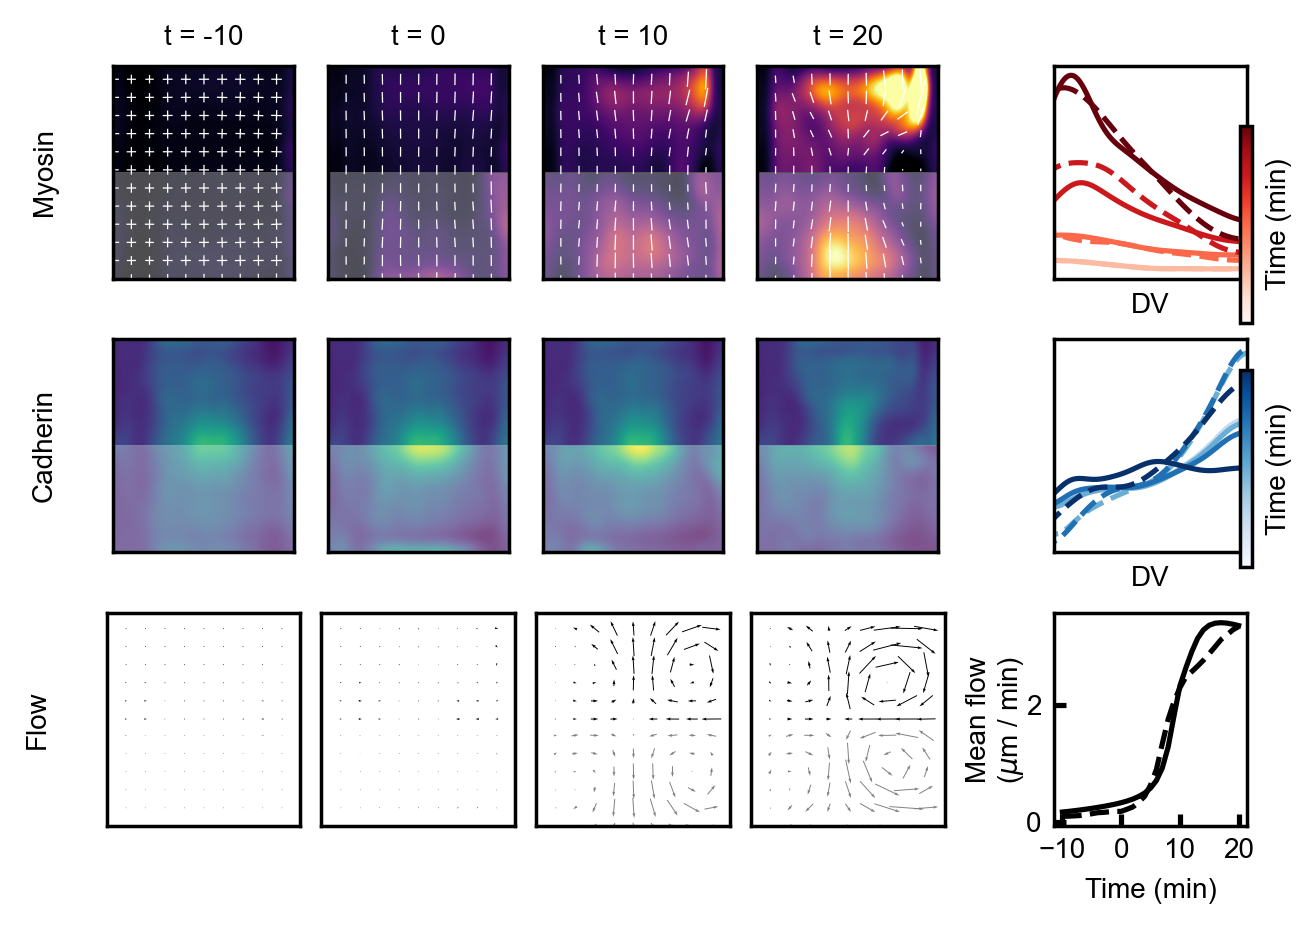

In [2]:
from morphogenesis.forecasting.closed_loop import ClosedFlyLoop
from morphogenesis.flow_networks.translation_models import VAE, MaskedVAE
from morphogenesis.flow_networks.forecasting_models import MaskedVAE_Evolver
from morphogenesis.forecasting.plot_utils import *
from morphogenesis.decomposition.decomposition_model import LeftRightSymmetrize
from pprint import pprint

# Collect model
vae = MaskedVAE(in_channels=4, 
                  out_channels=2, 
                  num_latent=64, 
                  stage_dims=[[32,32], [64,64], [128,128], [256,256]])

#info = torch.load('../04.TranslationNetworks/tb_logs/MaskedVAE_sqh_beta=1e-05_split=embryo', map_location='cpu')
#info = torch.load('../04.TranslationNetworks/tb_logs/MaskedVAE_sqh_beta=0.001_split=embryo', map_location='cpu')
info = torch.load('../04.TranslationNetworks/tb_logs/MaskedVAE_sqh_beta=0.0001_split=embryo', map_location='cpu') #Does best

vae.load_state_dict(info['state_dict'])
vae.to(device).eval()
pprint(info['hparams'])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    return VAE.forward(vae, y)[0]

#Collect initial conditions - m, c, v, and time
with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]

m0 = LeftRightSymmetrize().fit_transform(m0.reshape([-1, 4, 236, 200]))
s0 = LeftRightSymmetrize().fit_transform(s0.reshape([-1, 1, 236, 200]))
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])
y0 = torch.FloatTensor(y0)

def rhs_eCad(self, m, s, v, E):
    '''
    Compute the right hand side of the myosin dynamics
    '''
    trm = self.einsum_('kkyx->yx', m)
    trE = self.einsum_('kkyx->yx', E)

    rhs  = -(0.110 - 0.095 * s) * m #Detachment
    rhs +=	(0.802 - 0.611 * s) * trm * m #Tension recruitment
    rhs +=	(0.708 + 0.133 * s) * m * trE #Strain recruitment
    rhs +=	(0.064 - 0.044 * s) * trm * self.gamma_dv_ #Hoop stress recruitment

    return rhs


model = ClosedFlyLoop(v_model, sigma=5, rhs=rhs_eCad)#, geo_dir=None)
model.fit(y0[None])
model.float()

m, s, v = model.integrate(y0.to(device), t0)

comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Cadherin', s, s0),
    ('Flow', v, v0),
    dt=10)